In [266]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import torch 
import torch.nn as nn
import os
import shutil
from PIL import Image, ImageDraw
import numpy as np
from matplotlib.patches import Polygon
import torch.optim as optim
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchsummary import summary

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# cristian path 
base_dir = '/home/csalitre/school/ecgr-5106/final-project/' 


In [267]:
file_path_train = base_dir + '/semantic-segmentation/data/train/_annotations.coco.json'
file_path_valid = base_dir + '/semantic-segmentation/data/valid/_annotations.coco.json'   
file_paht_test = base_dir + '/semantic-segmentation/data/test/_annotations.coco.json'

# Doc file JSON
with open(file_path_train, 'r') as file:
    data_train = json.load(file)

with open(file_path_valid, 'r') as file:
    data_valid = json.load(file)

with open(file_paht_test, 'r') as file:
    data_test = json.load(file) 


In [268]:
categories_train = data_train['categories']
images_train = data_train['images']
annotations_train = data_train['annotations']

categories_valid = data_valid['categories']
images_valid = data_valid['images']
annotations_valid = data_valid['annotations']

categories_test = data_test['categories']
images_test = data_test['images']
annotations_test = data_test['annotations'] 

# print strucutre of data for debugging
#print(annotations_test[0])
print(images_train[0])
print(images_test[0])


{'id': 0, 'license': 1, 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
{'id': 0, 'license': 1, 'file_name': '1706_jpg.rf.004b87f63425ef145855aab826e33eee.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}


In [269]:
def create_maskGt(segmentations, input_image):
    """ 
    Create a mask from a list of segmentations.

    Args:
        segmentations: A list of segmentation polygons.
        input_image: The input image.

    Returns:
        A PIL Image object representing the mask.
    """ 
    mask = Image.new('L', (input_image.width, input_image.height), 0)
    draw = ImageDraw.Draw(mask)

    print("Segmentation polygons:", segmentations)  # Add this line to check the format of the segmentation polygons

    for polygon in segmentations:
        for i in range(0, len(polygon), 2):
            x = int(polygon[i])
            y = int(polygon[i + 1])
            draw.point((x, y), fill=1)

    return mask


In [270]:
import matplotlib.pyplot as plt

def visualize_masks(image, mask_gt, mask_pred_classic, mask_pred_finetune, figsize=(15, 15)):
    """
    Visualizes two masks side-by-side, along with the original image.

    Args:
        image: The original image.
        mask_gt: The ground truth mask.
        mask_gd: The predicted mask.
        figsize: The size of the figure.
    """

    # Create a new figure with three subplots.
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot the ground truth mask on the second subplot.
    axes[0].imshow(image)
    axes[0].imshow(mask_gt, alpha =0.5)
    axes[0].set_title("Ground Truth Mask")

    # Plot the predicted mask on the third subplot.
    axes[1].imshow(image)
    axes[1].imshow(mask_pred_classic, alpha =0.5)
    axes[1].set_title("Predicted Mask Classic")
    # Plot the predicted mask on the third subplot.
    axes[2].imshow(image)
    axes[2].imshow(mask_pred_finetune, alpha =0.5)
    axes[2].set_title("Predicted Mask Finetune")

    # Show the figure.
    plt.show()

In [271]:
file_path_train = base_dir + '/semantic-segmentation/data/train/'
file_path_valid = base_dir + '/semantic-segmentation/data/valid/'
file_path_test = base_dir + '/semantic-segmentation/data/test/'

"""
# Debug opening images : encountering No file found for .jpg
for image in images_train:
    image_path = os.path.join(file_path_train + image['file_name'])
    try: 
        with Image.open(image_path) as image_file:
            # Process the image
            pass 

    except FileNotFoundError as e:
        print(f"Error opening image: {image_path}")
        print(e)
"""

'\n# Debug opening images : encountering No file found for .jpg\nfor image in images_train:\n    image_path = os.path.join(file_path_train + image[\'file_name\'])\n    try: \n        with Image.open(image_path) as image_file:\n            # Process the image\n            pass \n\n    except FileNotFoundError as e:\n        print(f"Error opening image: {image_path}")\n        print(e)\n'

In [272]:
# For debugging purposes
"""
imgs_train = []
for image in images_train:
    imgs_train.append(Image.open(file_path_train + image['file_name']))

msks_train = []
for i in range(len(imgs_train)):
    image_obj = imgs_train[i]
    mask = create_maskGt(annotations_train[i]['segmentation'], image_obj)
    msks_train.append(mask)
    """

"\nimgs_train = []\nfor image in images_train:\n    imgs_train.append(Image.open(file_path_train + image['file_name']))\n\nmsks_train = []\nfor i in range(len(imgs_train)):\n    image_obj = imgs_train[i]\n    mask = create_maskGt(annotations_train[i]['segmentation'], image_obj)\n    msks_train.append(mask)\n    "

In [273]:

imgs_train = []
for image in images_train:
    imgs_train.append(Image.open(file_path_train + image['file_name']))

msks_train = []
for i in range(len(imgs_train)): 
    image_obj = imgs_train[i]       
    mask = create_maskGt(annotations_train[i]['segmentation'], image_obj)
    msks_train.append(mask)

imgs_val = []
for image in images_valid:
    imgs_val.append(Image.open(file_path_valid + image['file_name']))

msks_val = []
for i in range(len(imgs_val)):
    image_obj = imgs_val[i]
    mask = create_maskGt(annotations_valid[i]['segmentation'], image_obj)
    msks_val.append(mask)

imgs_test = []
for image in images_test:
    imgs_test.append(Image.open(file_path_test + image['file_name']))

msks_test = []
for i in range(len(imgs_test)):
    image_obj = imgs_test[i]
    mask = create_maskGt(annotations_test[i]['segmentation'], image_obj)
    msks_test.append(mask)

print(len(imgs_train))
print(len(msks_train))
print(len(imgs_val))
print(len(msks_val))
print(len(imgs_test))
print(len(msks_test))



Segmentation polygons: [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]]
Segmentation polygons: [[342.5, 176.25, 193.75, 176.25, 193.75, 410, 342.5, 410, 342.5, 176.25]]
Segmentation polygons: [[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295, 357.5, 295, 172.5]]
Segmentation polygons: [[383.75, 357.5, 245, 357.5, 245, 523.75, 383.75, 523.75, 383.75, 357.5]]
Segmentation polygons: [[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5, 321.25, 192.5, 188.75]]
Segmentation polygons: [[475, 150, 292.5, 150, 292.5, 285, 475, 285, 475, 150]]
Segmentation polygons: [[370, 165, 198.75, 165, 198.75, 298.75, 370, 298.75, 370, 165]]
Segmentation polygons: [[392.5, 287.5, 350, 287.5, 350, 340, 392.5, 340, 392.5, 287.5]]
Segmentation polygons: [[300, 250, 238.75, 250, 238.75, 337.5, 300, 337.5, 300, 250]]
Segmentation polygons: [[278.75, 138.75, 72.5, 138.75, 72.5, 305, 278.75, 305, 278.75, 138.75]]
Segmentation polygons: [[327.5, 225, 217.5, 225, 217.5, 323.75, 327.5, 323.75, 327.

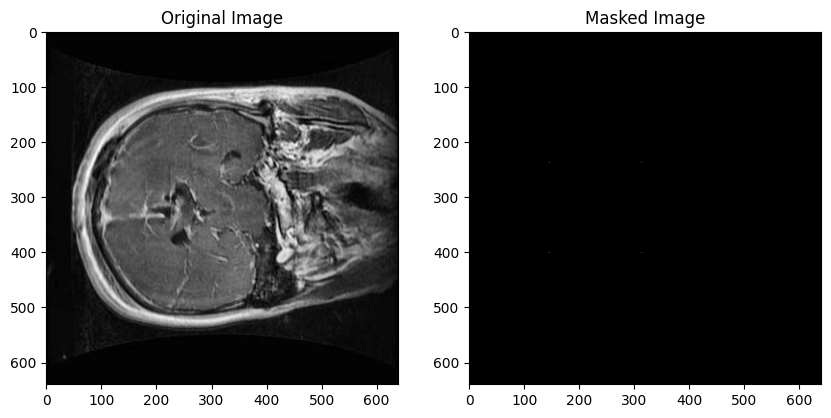

In [274]:
# Plot the original image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(imgs_train[0])
plt.title('Original Image')

# Plot the mask
plt.subplot(1,2,2)
plt.imshow(msks_train[0], cmap='gray')
plt.title('Masked Image')

plt.show()

In [275]:
# Define model
class ConvNextBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1):
        super(ConvNextBlock, self).__init__()
        self.dwconv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pwconv1 = nn.Conv2d(in_channels, 4 * out_channels, kernel_size=1)
        self.pwconv2 = nn.Conv2d(4 * out_channels, out_channels, kernel_size=1)
        self.norm = nn.BatchNorm2d(in_channels)
        self.act = nn.ReLU()

        

    def forward(self, x):
        residual = x
        out = self.dwconv(x)
        out = self.norm(out)
        out = self.act(out)
        out = self.pwconv2(out)
        out += residual
        return out

class ConvNeXt(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(ConvNeXt, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.block1 = ConvNextBlock(32, 64)
        self.block2 = ConvNextBlock(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(128 * 8 * 8 * 8 , num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

        

In [276]:
# Define criterion
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
    
    def forward(self, outputs, targets):
        smooth = 1e-5
        intersection = (outputs * targets).sum()
        union = outputs.sum() + targets.sum()
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1.0 - dice 

In [277]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, file_path, transform=None):
        self.images = images
        self.masks = masks
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]['file_name']  
        mask = self.masks[idx]

        # Construct full image path
        image_path = os.path.join(self.file_path, image_name)

        # Load image 
        image = Image.open(image_path)

        if self.transform:
            # Apply transformations
            transformed = self.transform(image=np.array(image), mask=np.array(mask))
            image = transformed['image']
            mask = transformed['mask']

        # Convert PIL image to tensor
        image = transforms.ToTensor()(image)

        # Convert mask to tensor
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension

        return image, mask


In [278]:
new_size = (352, 352)
batch_size = 32

transform = A.Compose([
    A.Resize(new_size[0], new_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10),
    ], additional_targets={'mask': 'image'})

# Assuming you have lists of images, masks, and annotations for train, val, and test sets
train_dataset = CustomDataset(images_train, msks_train, file_path_train, transform=transform)
val_dataset = CustomDataset(images_valid, msks_val, file_path_train, transform=transform)
test_dataset = CustomDataset(images_test, msks_test, file_path_train, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def train(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    """
    Trains a model using the given dataloaders.

    Args:
        model: The model to train.
        criterion: The loss function.
        optimizer: The optimizer to use.
        train_loader: The training dataloader.
        val_loader: The validation dataloader.
        num_epochs: The number of epochs to train for.
    """
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader, 0):
            inputs, masks = batch
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f"Epoch {epoch + 1}, iteration {i + 1}: {running_loss / 2000}")
                running_loss = 0.0

        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                inputs, masks = batch
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += masks.size(0)
                correct += (predicted == masks).sum().item()

        print(f"Epoch {epoch + 1}, validation accuracy: {100 * correct / total}%")

# Iterate over the data loader
for inputs, _ in train_loader:
    print("Input size:", inputs.shape)
    break 
model = ConvNeXt().to(device)
summary(model, input_size=(inputs.shape))

Input size: torch.Size([32, 3, 352, 352])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 32, 3, 352, 352]

In [ ]:
# Training Pipeline
model = ConvNeXt().to(device)
criterion = DiceLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epochs = 100

train(model, criterion, optimizer, train_loader, val_loader, num_epochs)

RuntimeError: Given groups=1, weight of size [64, 256, 1, 1], expected input[32, 32, 352, 352] to have 256 channels, but got 32 channels instead